# Twitter Fingers == Trigger Fingers: A Look at Gun Violence

## Data Acquisition and Cleaning Part 1:
Data was gathered from one main source, gunviolencearchive.org. Each individual reporting of gun violence comes with sources to prove that it happened, as well as details on the number injured, killed, date, time, and place. The first data acquisition takes these variables, puts them into a dataframe then into csv, as well as finds the source and cleans the links so that they are easily accessible. 

In [2]:
import pandas as pd
import requests
import urllib.request
from bs4 import BeautifulSoup
import re
import numpy as np
import socket
import scipy as sc
import datetime
import matplotlib
import matplotlib.pyplot as plt
import statistics
import datetime

**Functions**

In [ ]:
def transform_tables(pd_dataframe):
    # omit the hyperlink column that will be read as NA values
    new_dataframe = pd_dataframe.loc[:,"Incident ID":"# Injured"]
    # rename columns
    new_dataframe = new_dataframe.rename(columns = {"Incident ID": "ID", "Incident Date": "Date", 
                                    "State": "State", "City Or County": "City/County", 
                                    "Address": "Address", "# Killed": "Killed", 
                                    "# Injured": "Injured"})
    return new_dataframe

In [ ]:
def save_html(url, path):
    response = requests.get(url)
    with open(path, "wb") as file:
        file.write(response.content)

In [ ]:
def get_webpages(soup, year):
    last_webpage_href = soup.find('a', attrs={'title': "Go to last page"})
    last_webpage_path = last_webpage_href.get('href')
    number_of_other_pages = int(re.findall(r'%s(\d+)'%"page=", last_webpage_path)[0])
    if year in range(2014, 2016):
        webpage_paths = ['/reports/mass-shootings/'+ str(year)] # initialize with the first page's path
    else:
        webpage_paths = ['/reports/mass-shooting?year='+ str(year)]
    for page_number in range(1, number_of_other_pages + 1):
        path = re.sub(str(number_of_other_pages), str(page_number), last_webpage_path)
        webpage_paths.append(path)
    return webpage_paths

In [ ]:
def get_news_sources(soup):
    news_hrefs = soup.findAll('a', attrs={'href': re.compile("^https://|^http://")})
    news_links = [tag.get('href') for tag in news_hrefs if tag.text == "View Source"] # get all sources listed on a page
    return news_links

In [25]:
def remove_nesting(nested_list):
    return [i for j in nested_list for i in j]

**Acquisition and Cleaning**

In [ ]:
# get all pages paths

web_pages_paths = []
for year in range(2014, 2020):
    path = "mass_shooting_html_"+ str(year)
    soup = BeautifulSoup(open(path,'r'), 'html.parser')
    web_pages_paths.append(get_webpages(soup, year)) # including the first

In [ ]:
# save first pages html

for year in range(2014, 2020):
    if year in range(2014, 2016):
        first_page_url = "https://www.gunviolencearchive.org/reports/mass-shootings/" + str(year)
    else:
        first_page_url = "https://www.gunviolencearchive.org/reports/mass-shooting?year=" + str(year)
    path = "mass_shooting_html_"+ str(year) 
    save_html(first_page_url, path)

In [ ]:
sources_container = np.arange(2014, 2020, 1).tolist()
for year_index in range(len(sources_container)):
    year = 2014 + year_index
    sources_container[year_index] = []
    page_index = -1
    for path in web_pages_paths[year_index]:
        page_index += 1
        link = "https://www.gunviolencearchive.org" + path
        filename = "mass_shooting_html_"+ str(year) + "_page_" + str(page_index)
        #save_html(link, filename)
        soup = BeautifulSoup(open(filename,'r'), 'html.parser')
        this_page_sources = get_news_sources(soup)
        sources_container[year_index].append(this_page_sources) 
        
sources_container[5][8]

In [ ]:
news_2014 = remove_nesting(sources_container[0])
news_2015 = remove_nesting(sources_container[1])
news_2016 = remove_nesting(sources_container[2])
news_2017 = remove_nesting(sources_container[3])
news_2018 = remove_nesting(sources_container[4])
news_2019 = remove_nesting(sources_container[5])
news_2019[:5]

In [ ]:
# get the report tables

annual_reports = []
for year in range(2014, 2020):
    first_page_url = "https://www.gunviolencearchive.org/reports/mass-shootings/" + str(year)
    csv_file = str(year) + "_mass_shootings.csv"
    this_year_report = pd.read_csv(csv_file)
    cleaned_report = transform_tables(this_year_report)
    annual_reports.append(cleaned_report)
    

In [ ]:
ms_2014 = annual_reports[0]
ms_2015 = annual_reports[1]
ms_2016 = annual_reports[2]
ms_2017 = annual_reports[3]
ms_2018 = annual_reports[4]
ms_2019 = annual_reports[5]

ms_2019.head()

In [ ]:
ms_2014['Source'] = news_2014
ms_2015['Source'] = news_2015
ms_2016['Source'] = news_2016
try:
    ms_2017['Source'] = news_2017
except Exception as e:
    pass
ms_2018['Source'] = news_2018

# ms_2019['Source'] = news_2019 
# gives error since one row does not have a source listed directly

index = news_2019.index("https://www.wcvb.com/article/6-people-shot-outside-of-roxbury-party-police-say/28306883") # index of where it is supposed to be 
news_2019.insert(index, "https://fox2now.com/2019/07/07/north-county-residents-on-edge-after-5-adults-found-dead-in-apartment/")
news_2019 = [news_2019[i] for i in range(len(news_2019)) if news_2019[i] != news_2019[i-1]] 
# in case of re-running the insert code and duplicating

ms_2019['Source'] = news_2019 
ms_2019[:10]

In [ ]:
merged_data = pd.concat([ms_2014, ms_2015, ms_2016, ms_2017, ms_2018, ms_2019])
print(len(merged_data))
merged_data.to_csv(path_or_buf = "complete_project_dataset") # export as csv file

## Data Acquisition Part 2:
The second step of the data acquisition process was to access the sources, and find the article text from each source. This allows us to create a second set of data in a text file for analysis of all words from these articles, "articletext". 

In [ ]:
#reads in complete project data
gunviolencedataset = pd.read_csv("complete_project_dataset")
sourceurl = gunviolencedataset["Source"] #creates a series of just the source urls

The function that takes the source url, goes to the url, reads in the text from that site. The function then writes the text from the "p" tag to a text file, so that it can be accessed afterwards. 

In [ ]:
def getsourcetext(urlseries):
    #initialize beautifulsoup
    soup = BeautifulSoup('''<html>  </html>''', 'html.parser') 
    timeout = 20 #creates a timeout variable w an int
    socket.setdefaulttimeout(timeout) #uses timeout to set the socket timeout
    dictionary = {}
    for k in urlseries: #runs this loop for every entry in the series
        try:
            html = urllib.request.urlopen(url=k) #opens k website
            html = html.read() #reads in website info
            htmlfile = html.decode('utf-8') #decodes the info into a new file
        #need to make exceptions for 404/403/etc
        except Exception as e:
            continue
        else: #what to do after try block works or doesn't work
            singlesoup = BeautifulSoup(htmlfile, 'html.parser') #the variable that holds the data from the article
            full_text = ""
            for n in singlesoup("p"): #finds p tag (the main paragraph of the article)
                full_text += n.get_text(strip=True)#we only want the parts of the article that are from the main paragraph
        dictionary[k] = full_text  
    return dictionary

text_dict_of_1000 = getsourcetext(sourceurl[:1000]) # it takes 1 hour to work the first 1000 urls 

In [ ]:
# Finalized dataframe and save as csv file
full_text_df = pd.DataFrame(list(text_dict_of_1000.items()),
                   columns=['Source', 'Text'])
merged_1000_df = pd.merge(gunviolencedataset, full_text_df, on = "Source")
merged_1000_df.to_csv(path_or_buf = "first_1000_dataset_with_text") 

# get the final version of the data by running this code below 

In [5]:
# Read in the created csv file above
imported_df = pd.read_csv("first_1000_dataset_with_text")
imported_df['Date'] = imported_df['Date'].apply(lambda x: datetime.datetime.strptime(x,"%B %d, %Y"))
imported_df = imported_df.sort_values(by = 'Date')
no_na = imported_df.dropna()

# visually inspection show text with 300 or less characters are not article body
# for string in merged_1000_df["Text"]:
#     if len(string) < 300:
#         print(string)
#         print("\n")

data = no_na.loc[no_na["Text"].str.len() > 300]
data = data.iloc[:, 2:11]

print(data.shape)
data.head()

(523, 9)


,ID,Date,State,City/County,Address,Killed,Injured,Source,Text
120,94514,2014-01-05,Pennsylvania,Erie,829 Parade St,1,3,https://www.erienewsnow.com/story/24366744/1-k...,Shots were fired around 1 a.m. Sunday morning ...
119,95146,2014-01-11,Mississippi,Jackson,3430 W. Capitol Street,0,4,https://www.wlbt.com/story/24423205/six-shot-i...,"JACKSON, MS (Mississippi News Now) - Jackson p..."
118,95550,2014-01-12,Alabama,Huntsville,University Drive,0,5,http://blog.al.com/breaking/2014/01/huntsville...,benchwarmerHuntsville police have arrested a 1...
117,95579,2014-01-12,Illinois,Elgin,300 block of North St,0,5,http://www.chicagotribune.com/news/local/break...,A 16-year-old boy has been charged with killin...
116,96792,2014-01-14,California,Los Angeles,West 86th Street,0,4,http://ktla.com/2014/01/14/4-injured-in-south-...,KTLAby:Melissa PamerFour people were wounded i...


After scraping from the sources of the first 1000 incidents sorted in chronological order, we have all a total of 523 rows. This is due to various reason pertaining to web update: 
- urls did not work gives 404 status code
- article no longer exist
- video content

## Exploratory Analysis:
After obtaining and cleaning the data, we wanted to look at the statistics and visualization of the data gathered. 

In [6]:
dates = []
num_killed = []
num_injured = []

for row in range(len(data)):
    x = data.iloc[row,1]
    if x in dates:
        num_killed[len(num_killed)-1]+= data.iloc[row,5]
        num_injured[len(num_injured)-1]+= data.iloc[row,6]
    else:
        dates.append(x)
        num_killed.append(data.iloc[row,5])
        num_injured.append(data.iloc[row,6])
        

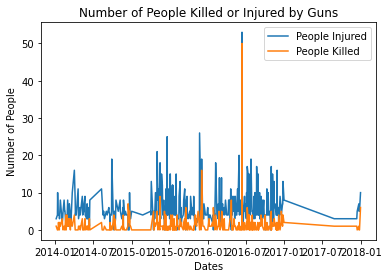

In [7]:
plt.plot(dates, num_injured, label = "People Injured")
plt.plot(dates, num_killed, label = "People Killed")

# naming the x axis
plt.xlabel('Dates')
# naming the y axis
plt.ylabel('Number of People')
# giving a title to my graph
plt.title('Number of People Killed or Injured by Guns')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()

In [8]:
d = {'statistic' : ['mean','median','mode','std','min','max'], 
     'Number Killed' : [np.mean(num_killed),np.median(num_killed),statistics.mode(num_killed),np.std(num_killed),min(num_killed),max(num_killed)],
    'Number Injured' : [np.mean(num_injured),np.median(num_injured),statistics.mode(num_injured),np.std(num_injured),min(num_injured),max(num_injured)]
    }

stats_of_the_data = pd.DataFrame(data = d)
print(stats_of_the_data)

  statistic  Number Killed  Number Injured
0      mean       1.442308        6.082418
1    median       1.000000        4.000000
2      mode       0.000000        4.000000
3       std       3.084786        4.800849
4       min       0.000000        0.000000
5       max      50.000000       53.000000


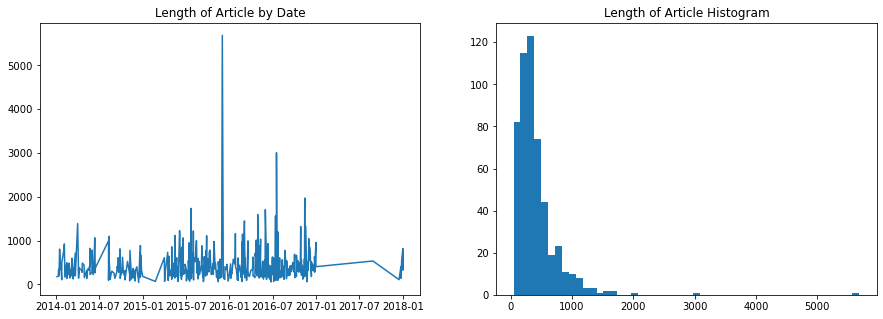

In [9]:
words = data["Text"].str.split()
words = words.map(lambda x: len(x))

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(data["Date"], words)
axs[0].set_title("Length of Article by Date")
axs[1].hist(words, bins = 50)
axs[1].set_title("Length of Article Histogram")
plt.show()

The length of the article seems to correlate with the trend in the number of injured or killed victims.

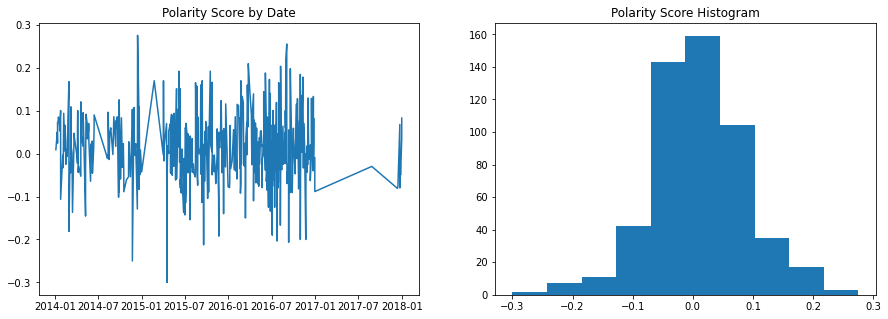

In [10]:
from textblob import TextBlob # simple library; sutiable for exploratory analysis
def polarity(text):
    return TextBlob(text).sentiment.polarity 

polarity_score = data['Text'].apply(lambda x : polarity(x))

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(data["Date"], polarity_score)
axs[0].set_title("Polarity Score by Date")
axs[1].hist(polarity_score)
axs[1].set_title("Polarity Score Histogram")
plt.show()

The polarity score distribution determined by TextBlob.sentiment.polarity is centered at 0 with a small deviation. The articles are mostly neutral.

## Analysis Method Outlines: N-grams and Sentiment Analysis Classification

**NLP Analysis:** We wanted to use Natural Language Processing to inspect the relations of words in the articles we find, in the hopes that we can relate fequency of word use and the context that these fequently used words are in to the increase of gun violence in America. To start this the article text extracted must be tokenized (sorted into words), remove the words and punctuation that are too common to be useful, and assess the frequency of the cleaned words. Then ngrams are created of these words to assess the context that the frequent words come in. 

What remains to be done is connect these results to collective meaning about the articles, and how that relates to gun violence. 

In [11]:
import nltk
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

# make list of stopwords, numbers, and punctuation
stopwords = nltk.corpus.stopwords.words('english')
capstopwords = [w.title() for w in stopwords]
numbers = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "zero"]
stopwords.extend(capstopwords)
stopwords.extend(numbers)

In [14]:
# keywordstuple_list = []
# for article in data["Text"]:
#     tokenizer = RegexpTokenizer(r'\w+')
#     articletext = tokenizer.tokenize(article)
#     articletext = [word.lower() for word in articletext if word not in stopwords]
#     frequency_dist = FreqDist(articletext)
#     keywordstuple = frequency_dist.most_common(10)
#     keywordstuple_list.append(list(keywordstuple))

# keywordstuple_list 

In [ ]:
#ngram analysis of text
bigrams = nltk.bigrams(articletext)
trigrams = nltk.trigrams(articletext)
bigramlist = list(bigrams)
trigramlist = list(trigrams)
#need to find the keywords in the ngrams
keywordbigrams = [word_tuple for word_tuple in bigramlist if ((word_tuple[0] in keywords) | (word_tuple[1] in keywords))]
keywordtrigrams = [word_tuple for word_tuple in trigramlist if ((word_tuple[0] in keywords) | (word_tuple[1] in keywords) | (word_tuple[2] in keywords))]
#

**Sentiment Analysis:** Our second kind of analysis for the article is going to be sentiment analysis classification. We created a classification model that trains on a library of tweets that are rated from 0 through 4 on a negative-positive scale. The tweet is vectorized into features and its rating. 

In [15]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
try:
    from gensim.models import Word2Vec
except Exception as e:
    pass
from collections import Counter

import nltk
#nltk.download('all')

/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Importing and trimming twitter sentiment dataset

Insert header, remove numbers, usernames, and NO_QUERY

Move first row that became header down to data, add headers

In [18]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding = "ISO-8859-1",names=["score","id","datetime","NO_QUERY","usernames","tweet"])

df = df.drop(['id','NO_QUERY','usernames'],axis=1)

df.head()

,score,datetime,tweet
0,0,Mon Apr 06 22:19:45 PDT 2009,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,Mon Apr 06 22:19:49 PDT 2009,is upset that he can't update his Facebook by ...
2,0,Mon Apr 06 22:19:53 PDT 2009,@Kenichan I dived many times for the ball. Man...
3,0,Mon Apr 06 22:19:57 PDT 2009,my whole body feels itchy and like its on fire
4,0,Mon Apr 06 22:19:57 PDT 2009,"@nationwideclass no, it's not behaving at all...."


Checking count values, dataset listed from 0 = negative to 4 = positive. 

In [19]:
df = df.iloc[0:20000, :]
print(df.shape)
print(df['score'].value_counts())

(20000, 3)
0    20000
Name: score, dtype: int64


Clean up links, @users, hastags

In [20]:
stopwords = nltk.corpus.stopwords.words("english")

def cleanup(text):
    clean = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",str(text)).split()
    tokens = []
    for token in clean:
        if token not in stopwords:
            tokens.append(token)
    return tokens

In [21]:
df['tweet'] = df['tweet'].apply(lambda x: cleanup(x))

df['score'] = df['score'].replace([0,4],['neg','pos']) 

df.head()

,score,datetime,tweet
0,neg,Mon Apr 06 22:19:45 PDT 2009,"[Awww, bummer, You, shoulda, got, David, Carr,..."
1,neg,Mon Apr 06 22:19:49 PDT 2009,"[upset, update, Facebook, texting, might, cry,..."
2,neg,Mon Apr 06 22:19:53 PDT 2009,"[I, dived, many, times, ball, Managed, save, 5..."
3,neg,Mon Apr 06 22:19:57 PDT 2009,"[whole, body, feels, itchy, like, fire]"
4,neg,Mon Apr 06 22:19:57 PDT 2009,"[behaving, mad, I, see]"


In [22]:
def to_tuple(x):
    subset = x[['tweet','score']]
    tuples = [tuple(i) for i in subset.to_numpy()]
    return tuples

In [23]:
documents = to_tuple(df)
documents[0] # tuple of tokens and score

(['Awww',
  'bummer',
  'You',
  'shoulda',
  'got',
  'David',
  'Carr',
  'Third',
  'Day',
  'D'],
 'neg')

In [26]:
# def word_master(x):
#     master_list = []
#     for i in range(len(x)):
#         master_list += x['tweet'][i] 
#     return master_list

words = remove_nesting(df['tweet'])

word_features = nltk.FreqDist(w.lower() for w in words).most_common(2000)
word_features =  [word_tuple[0] for word_tuple in word_features]
word_features[0:5] 

['i', 'work', 'go', 'get', 'day']

In [ ]:
def document_features(document):    
    document_words = set(document) 
    features = {}
    for word in word_features:
        features['contains('+ word +')'] = (word in document_words) 
    return features

featuresets = [(document_features(d), c) for (d,c) in documents] 
featuresets[1]

The words as feature vectors have been computed, this then establishes the training and test sets. Then runs the classification model on the test set. 

What remains to be done here is test the model on the article data which also needs to be turned into feature vectors. 

In [28]:
train_set, test_set = featuresets[100:], featuresets[:100]
classifier = nltk.NaiveBayesClassifier.train(train_set)

print(nltk.classify.accuracy(classifier, test_set))

classifier.show_most_informative_features(10)

1.0
Most Informative Features


In [33]:
text_labels = []
for article in data["Text"]:
    tokenizer = RegexpTokenizer(r'\w+')
    articletext = tokenizer.tokenize(article)
    articletext = [word.lower() for word in articletext if word not in stopwords]
    text_labels.append(classifier.classify(document_features(article)))

(array([  0.,   0.,   0.,   0.,   0., 523.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

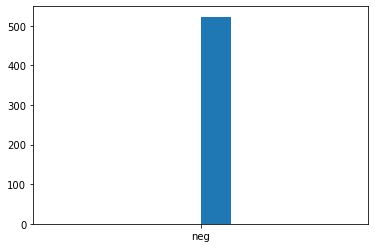

In [38]:
plt.hist(text_labels)

# Ethical Considerations

The gun violence data is collected manually from reliable news and police reports in an organized manner and is intended for public use. Since we are not republishing any material or using any metadata, there is also no conflict with the Rights and Limit of Use stated by the aforementioned news outlets.

There could be some unintended bias in the data collection: all incidents with dysfunctional links were ommitted. It would be very time-consuming and ineffective to find substitute urls otherwise. 